# Exploratory Data Analysis

## Imports

In [255]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [256]:
train: pd.DataFrame = pd.read_csv('data/no1_train.csv')
train.set_index('start_time', inplace=True)
test: pd.DataFrame = pd.read_csv('data/no1_validation.csv')
test.set_index('start_time', inplace=True)
train.head()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
start_time,,,,,,,,,
2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


In [257]:
train.describe()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
count,225088.000000,225088.000000,225088.000000,225088.000000,225088.0,225088.000000,225088.000000,225088.000000,225088.000000
mean,1888.334127,224.189826,21.803497,55.703266,0.0,2190.031963,8.907921,-8.284305,-1999.055081
std,401.000305,58.559855,3.579229,47.053033,0.0,444.077730,320.262539,43.748315,1311.682286
min,683.438000,80.371000,0.000000,0.000000,0.0,849.732000,-1579.680903,-828.000000,-5541.200000
25%,1625.029000,185.017000,22.100000,15.704000,0.0,1916.523000,-142.226700,0.000000,-2996.700000
50%,1933.916000,225.938000,22.100000,41.848000,0.0,2248.874000,-11.282351,0.000000,-1953.700000
75%,2175.595000,269.558000,24.100000,88.723000,0.0,2497.792000,127.454943,0.000000,-906.900000
max,2995.524000,349.271000,25.700000,176.000000,0.0,3351.974000,2956.333317,474.000000,723.400000


## Data inspection

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

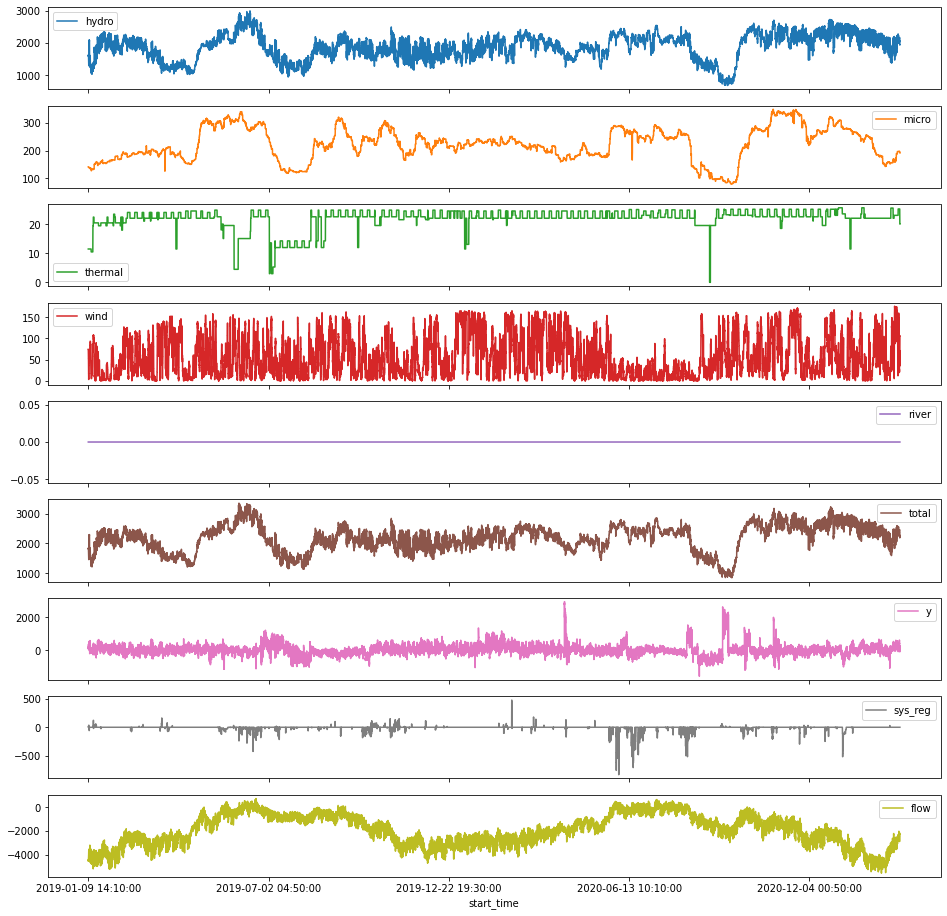

In [258]:
train.plot(subplots=True, figsize=(16,16))

<AxesSubplot:>

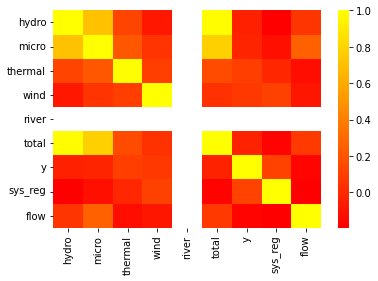

In [259]:
sns.heatmap(train.corr(), xticklabels=train.columns, yticklabels=train.columns, cmap='autumn')

### Preprocessing

2250
Index(['2020-04-12 04:15:00', '2020-04-12 04:10:00', '2020-04-12 04:20:00',
       '2020-04-12 03:50:00', '2020-04-12 01:25:00', '2020-04-12 01:30:00',
       '2020-04-12 04:05:00', '2020-04-12 01:10:00', '2020-04-12 01:15:00',
       '2020-04-12 04:55:00',
       ...
       '2020-09-12 01:30:00', '2019-06-29 04:00:00', '2020-08-12 04:55:00',
       '2020-08-11 04:15:00', '2020-09-13 10:15:00', '2020-08-12 05:15:00',
       '2020-09-12 03:25:00', '2019-06-27 21:45:00', '2020-09-12 09:45:00',
       '2020-09-12 01:25:00'],
      dtype='object', name='start_time', length=2181)


array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

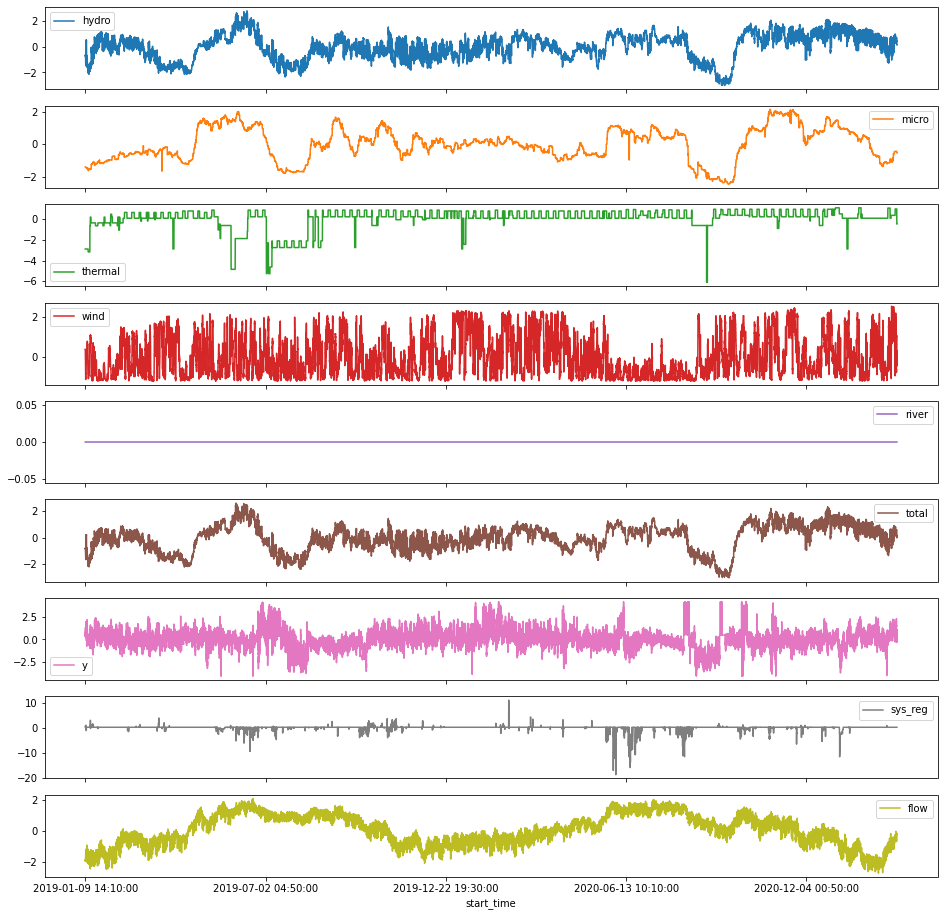

In [260]:
from preprocessing.preprocessor import Preprocessor

train_p = Preprocessor.clip(train, columns=['y'])
train_p = Preprocessor.scale(train_p)
train_p.plot(subplots=True, figsize=(16,16))

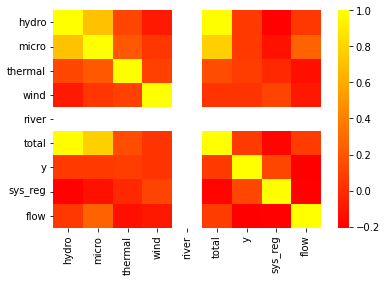

In [261]:
ax = sns.heatmap(train_p.corr(), xticklabels=train_p.columns, yticklabels=train_p.columns, cmap='autumn')
plt.show()

# Feature engineering

In [262]:
from preprocessing.feature_engineering import add_time_features

train_f = add_time_features(train_p)

In [263]:
train_f.sample()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,time_of_week,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,time_of_day_4,time_of_day_5
start_time,,,,,,,,,,,,,,,,,,,,
2019-06-01 02:40:00,0.891006,1.509334,-4.834431,-0.471645,0.0,0.914666,0.70363,0.143647,1.300131,0,1,0,0,1,1,0,0,0,0,0


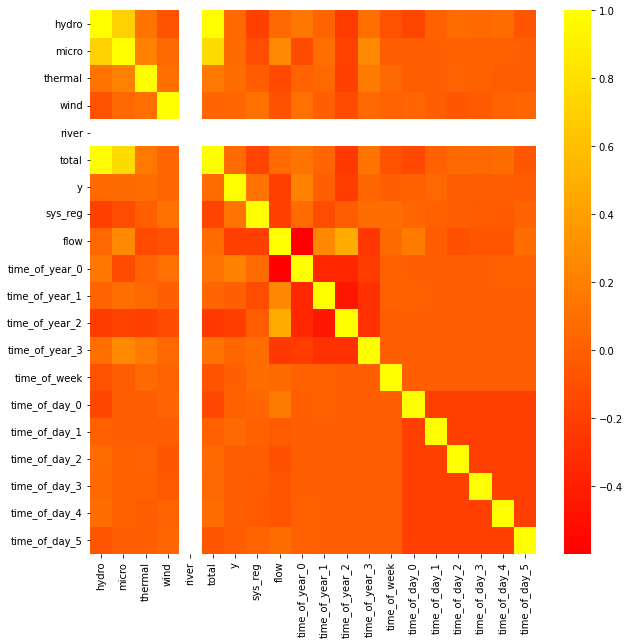

In [264]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(train_f.corr(), xticklabels=train_f.columns, yticklabels=train_f.columns, cmap='autumn')
plt.show()